In [22]:
import pandas as pd
import pickle
from tqdm import tqdm
from src.data.hex_utils import *

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox
from matplotlib import patches
import numpy as np
from pyproj import Transformer

In [66]:
a = 2
b = 5.5
(b - a) // 1 * 1

3.0

In [77]:
def get_hex_size(limits, n_rows):
    return (limits[1, 1] - limits[0, 1]) / ((n_rows + 0.5) * np.sqrt(3))


def hexagonize(df, n_rows, limits):
    hex_size = get_hex_size(limits=limits, n_rows=n_rows)

    xy = df[["lon", "lat"]].values
    hdf = df.copy()
    qr = coords_to_hex(xy, hex_size, limits[0])
    hdf["q"] = qr[:, 0]
    hdf["r"] = qr[:, 1]
    return hdf


def hex_to_coords(qr, hex_size, coord_offset):
    a = np.array([[1.5, 0.5 * np.sqrt(3)], [0, np.sqrt(3)]])
    return qr @ a * hex_size + coord_offset


def coords_to_hex(coords: np.ndarray, hex_size: float, coord_offset: np.ndarray):
    """Converts geo-coordinates to axial hexgrid coordinates

    Parameters
    ----------
    coords : np.ndarray
        Coordinates of shape (n, 2) to convert to match to hexgrid.
    hex_size : float
        Size of hexagons.

    Returns
    -------
    Axial coordinates of form [q, r]
    """
    pixels = coords - coord_offset
    a = np.array([[2, -1], [0, np.sqrt(3)]]) / 3
    fracs = pixels @ a / hex_size

    return cell_round(fracs)


def get_hex_traj(traj, n_rows, limits):
    size = get_hex_size(limits, n_rows)
    xys = hex_to_coords(traj, size, limits[0])
    hexagons = [
        patches.RegularPolygon(
            xy,
            numVertices=6,
            radius=size,
            orientation=np.radians(30),
            edgecolor="k",
            facecolor=(0.1, 0.2, 0.8, 0.5),
            linewidth=0.5,
        )
        for xy in xys
    ]

    return hexagons


def get_hexgrid(
    limits,
    patch=None,
    n_rows=None,
    size=None,
):
    if size is None:
        size = get_hex_size(limits, n_rows)
    xstep = 3 / 2 * size
    ystep = np.sqrt(3) * size

    step = np.array([xstep, ystep])
    offset = (patch[0] - limits[0]) // step * step
    x = np.arange(limits[0, 0] + offset[0], patch[1, 0], xstep)  # (n_cols)
    y = np.arange(limits[0, 1] + offset[1], patch[1, 1], ystep)  # (n_rows)

    n_cols, n_rows = len(x), len(y)
    xs, ys = np.meshgrid(x, y)  # (n_rows, n_cols), (n_rows, n_cols)
    xy = np.stack([xs, ys], axis=-1)  # (n_rows, n_cols, 2)
    odd_cols = np.arange(1, n_cols, 2)
    xy[:, odd_cols, 1] += ystep / 2
    xy = xy.reshape(-1, 2)

    hexagons = [
        patches.RegularPolygon(
            xyi,
            numVertices=6,
            radius=size,
            orientation=np.radians(30),
            edgecolor="k",
            facecolor='none',
            linewidth=0.5,
        )
        for xyi in xy
    ]

    return hexagons

In [85]:
import torch
l = [torch.ones(3) for i in range(3)]
sum(l)

TypeError: sum(): argument 'input' (position 1) must be Tensor, not list

In [78]:
crs1 = "epsg:4326"
crs2 = "epsg:3857"
limits = np.array([[116.1, 39.7], [116.7, 40.1]])
n_rows = 100

transformer = Transformer.from_crs(crs1, crs2)

with open("../data/processed/geolife.pkl", "rb") as f:
    gdf = pickle.load(f)

gdf = gdf[gdf["t_idx"] == 1]
lon, lat = transformer.transform(gdf["lat"], gdf["lon"])
gdf["lon"] = lon
gdf["lat"] = lat

lonlimit, latlimit = transformer.transform(limits[:, 1], limits[:, 0])
limits= np.array([lonlimit, latlimit]).T

hdf = hexagonize(gdf, n_rows=n_rows, limits=limits)
tmp = []
for t_idx, dft in hdf.groupby("t_idx"):
    tmp.append(interpolate_cell_jumps(dft))
hdf = pd.concat(tmp)
# hdf = hdf.groupby("t_idx").filter(lambda x: len(x) >= 3)

In [83]:
dict(hdf[['q', 'r']].nunique())

{'q': 10, 'r': 8}

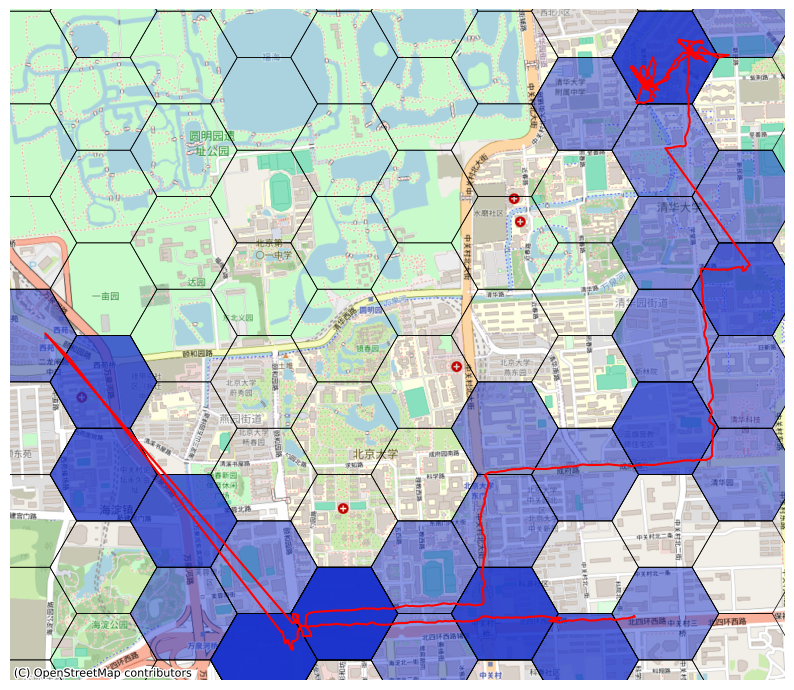

In [79]:
fig, ax = plt.subplots(figsize=(10, 10))
traj_idx = 1
padding = 1e-4

# Plot the line on the transformed coordinates
ax.plot(gdf["lon"], gdf["lat"], marker="o", markersize=0, color="red", linestyle="-", label="Path")


# Add the OpenStreetMap basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

n_rows = 100

# Create the hexagonal grid
hexagons = get_hex_traj(hdf[['q', 'r']].values, n_rows, limits)
for hexagon in hexagons: 
    ax.add_patch(hexagon)

hexagons = get_hexgrid(
    limits, patch=np.array([ax.get_xlim(), ax.get_ylim()]).T, n_rows=n_rows
)
for hexagon in hexagons:
    ax.add_patch(hexagon)

ax.set_aspect("equal")
ax.autoscale_view()
plt.axis("off")
plt.show()

In [6]:
crs2 = "epsg:2333"
lonlimits = [116.1, 116.7]
latlimits = [39.7, 40.1]
n_rows = 100

limits = gpd.points_from_xy(x=lonlimits, y=latlimits, crs="epsg:4326")
limits = limits.to_crs(crs2)
size = get_hex_size(limits, n_rows)

grid = get_hexgrid(limits=limits, size=size)
grid_filtered = grid.merge(hex_traj, on=["q", "r"])
map = folium.Map(location=(40.2, 116.383331), zoom_start=8.2)
pgrid = grid.to_crs("epsg:4326")
grid_json = pgrid.to_json()
tooltip = folium.GeoJsonTooltip(fields=["q", "r"])


grid_layer = folium.GeoJson(
    grid_json,
    tooltip=tooltip,
)
grid_layer.add_to(map)
map

NameError: name 'hex_traj' is not defined